# ML Models
## Machine Learning on Mortgage Loans
### CAPP 30245 - Jacob Leppek, Rob Mitchell, Ryan Webb

***
Our analysis attempts to predict whether a completed mortgage loan application is approved or not using 2017 nationwide Consumer Financial Protection Bureau data accessed [here](https://www.consumerfinance.gov/data-research/hmda/). This data is accessible under the Home Mortgage Disclosure Act. We use 3 primary classification models to predict whether loans are approved: Decision Tree / Random Forest, Logistic Regression, and KNN. We break out these results to examine the importance of race in our models and its predictive power. We use multiple evaluation metrics to compare models: **INSERT METRICS HERE**. 

Overall, we find that **INSERT BEST MODEL HERE** is the most predictive model with an accuracy of **INSERT ACCURACY HERE** using features of **INSERT FEATURES HERE**.

This analysis does not claim any interpretation as to the likelihood that an applicant can successfully pay back the loan, as the HMDA data does not include the relevant variables. The lack of a credit history, for instance, is a variable unreported by the HMDA but essential in the decision to originate (approve) a loan or not. 

These unreported variables do lead some academics to [question the validity](https://www.depauw.edu/learn/stata/Workshop/Munnell.pdf) of prior analyses that aim to demonstrate discrimination and borrowing credibility. To this, we can not directly estimate the causal effect of race or any other applicant characteristic has on the probability of a loan being approved. 

For this analysis, we seek only to determine whether, from the variables provided, whether we can predict if a loan is approved or denied. 

Code explanations for each feature may be accessed [here](https://files.consumerfinance.gov/hmda-historic-data-dictionaries/lar_record_codes.pdf).

In this notebook, we create and evaluate our machine learning models. 

### Obtain Data

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn import linear_model, decomposition
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, plot_precision_recall_curve

In [52]:
x_train = pd.read_csv('x_train.csv')
x_test = pd.read_csv('x_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

While a few geographic variable and categorical indicators remain in the training and testing sets, we are only using select features for the tree based models. 

In [19]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
test = sel.fit_transform(x_train)

### Classification Models

We started with a simple decision tree, similar to problem set 4. We impute the remaining missing values for *loan_amount_000s* and *applicant_income_000s* based on the median value using SimpleImputer to obtain more accurate estimates, and recreate the DataFrame, as SimpleImputer does not return a dataframe. 

In [53]:
features = x_train.columns.values
impute_features = SimpleImputer(missing_values=np.nan, strategy='median')
x_train = pd.DataFrame(impute_features.fit_transform(x_train))
x_train.columns = ['loan_amount_000s', 'census_tract_number', 'preapproval',
                   'applicant_ethnicity', 'co_applicant_ethnicity', 'applicant_race_1',
                   'co_applicant_race_1', 'applicant_sex', 'co_applicant_sex',
                   'applicant_income_000s', 'hoepa_status', 'lien_status', 'population',
                   'minority_population', 'hud_median_family_income',
                   'tract_to_msamd_income', 'number_of_owner_occupied_units',
                   'number_of_1_to_4_family_units', 'co_applicant']

#impute test set with training medians
fill_values = dict(zip(features, impute_features.statistics_))
x_test = x_test.fillna(value=fill_values)

Then, we use a Decision Tree Classifier, Random Forest Classifier, and Logistic Regression models. All of these are classification models that allow us to predict binary outcomes. 

#### Decision Tree Classifier

We first create a decision tree classifier with all variables, using a GridSearch and cross validation (k=10). We set the hyperparameters as follows: max_depth, 1,3,5; criterion, entropy and gini. We leave min_samples_split at its default; we tried values up to 50,000 with no discernible changes in accuracy. Additionally, this is not a regression tree, so no smoothing is needed. 

In [49]:
parameters_dtc = {'random_state':[0],'max_depth':[1,3,5],'criterion':['entropy', 'gini']}

grid_dtc = GridSearchCV(DecisionTreeClassifier(), parameters_dtc,
                        scoring = ['accuracy', 'recall', 'precision'], cv=10, 
                        refit='accuracy', n_jobs=-1, verbose=2)

grid_dtc.fit(x_train, y_train)

results_dtc = pd.DataFrame.from_dict(grid_dtc.cv_results_)
results_dtc[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.5min finished


,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'entropy', 'max_depth': 1, 'rand...",0.869469,1.000000,0.869469
1,"{'criterion': 'entropy', 'max_depth': 3, 'rand...",0.872204,0.997950,0.873188
2,"{'criterion': 'entropy', 'max_depth': 5, 'rand...",0.874644,0.996802,0.876095
3,"{'criterion': 'gini', 'max_depth': 1, 'random_...",0.869469,1.000000,0.869469
4,"{'criterion': 'gini', 'max_depth': 3, 'random_...",0.872435,0.998623,0.872952
5,"{'criterion': 'gini', 'max_depth': 5, 'random_...",0.874282,0.996828,0.875756


Next we try the same hyperparameters and model, but using only Census indicators:

In [57]:
x_train_census  = x_train.loc[:, ['census_tract_number', 'population', 'minority_population',
                    'hud_median_family_income', 'tract_to_msamd_income',
                    'number_of_owner_occupied_units', 'number_of_1_to_4_family_units']]

In [58]:
parameters_dtc = {'random_state':[0],'max_depth':[1,3,5],'criterion':['entropy', 'gini']}

grid_dtc = GridSearchCV(DecisionTreeClassifier(), parameters_dtc,
                        scoring = ['accuracy', 'recall', 'precision'], cv=10, 
                        refit='accuracy', n_jobs=-1, verbose=2)

grid_dtc.fit(x_train_census, y_train)

results_dtc = pd.DataFrame.from_dict(grid_dtc.cv_results_)
results_dtc[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.7min finished


,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'entropy', 'max_depth': 1, 'rand...",0.869469,1.0,0.869469
1,"{'criterion': 'entropy', 'max_depth': 3, 'rand...",0.869469,1.0,0.869469
2,"{'criterion': 'entropy', 'max_depth': 5, 'rand...",0.869469,1.0,0.869469
3,"{'criterion': 'gini', 'max_depth': 1, 'random_...",0.869469,1.0,0.869469
4,"{'criterion': 'gini', 'max_depth': 3, 'random_...",0.869469,1.0,0.869469
5,"{'criterion': 'gini', 'max_depth': 5, 'random_...",0.869469,1.0,0.869469


Lastly, we again use a Decision Tree Classifier and the same hyperparameters while using the same Census indicators above with the applicant demographic characteristics (race, sex, and ethnicity).
**It's likely that these variables are correlated; should we show a visualization about this?**

In [60]:
x_train_census_traits = x_train.loc[:, ['applicant_ethnicity', 'co_applicant_ethnicity', 'applicant_race_1',
                           'co_applicant_race_1', 'applicant_sex', 'co_applicant_sex',
                            'census_tract_number', 'population', 'minority_population',
                            'hud_median_family_income', 'tract_to_msamd_income',
                            'number_of_owner_occupied_units', 'number_of_1_to_4_family_units']]

In [62]:
parameters_dtc = {'random_state':[0],'max_depth':[1,3,5],'criterion':['entropy', 'gini'], 'min_samples_leaf':[1,5000, 50000]}

grid_dtc = GridSearchCV(DecisionTreeClassifier(), parameters_dtc,
                        scoring = ['accuracy', 'recall', 'precision'], cv=10, 
                        refit='accuracy', n_jobs=-1, verbose=2)

grid_dtc.fit(x_train_census_traits, y_train)

results_dtc = pd.DataFrame.from_dict(grid_dtc.cv_results_)
results_dtc[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 16.3min finished


,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.869469,1.000000,0.869469
1,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.869469,1.000000,0.869469
2,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.869469,1.000000,0.869469
3,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.870025,0.999632,0.870190
4,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.869469,1.000000,0.869469
5,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.869469,1.000000,0.869469
6,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.870569,0.997049,0.872339
7,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.870014,0.997753,0.871395
8,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.869469,1.000000,0.869469
9,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.869469,1.000000,0.869469


##### Random Forest Classifier

We now try a Random Forest Classifier to improve the accuracy of our estimates. Since we have millions of observations, we only use a sample of the data to improve training time of the model. We do not use a GridSearchCV. We also only use Gini as a measure of impurity to make computation easier.

Ideally, this will limit any overfitting in the model.

In [ ]:
sample = 

In [63]:
parameters = {'random_state':[0],
              'n_estimators':[100],
              'max_depth':[3],
              'criterion':['gini']}

grid_r = GridSearchCV(RandomForestClassifier(),
                      parameters,
                      scoring = ['accuracy', 'recall', 'precision'],
                      cv=10, refit='accuracy', n_jobs = -1,verbose=2)

y_train_array = np.array(y_train).reshape(-1)

grid_r.fit(x_train, y_train_array)

results_r = pd.DataFrame.from_dict(grid_r.cv_results_)
results_r[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 59.4min remaining: 25.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 68.4min finished
C:\Users\Jacob\miniconda3\envs\capp30245\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'gini', 'max_depth': 3, 'n_estim...",0.869469,1.0,0.869469


In [ ]:
parameters_rf2 = {'random_state':[0],
              'n_estimators':[100],
              'max_depth':[5],
              'criterion':['gini']}

grid_rf2 = GridSearchCV(RandomForestClassifier(),
                      parameters_rf2,
                      scoring = ['accuracy', 'recall', 'precision'],
                      cv=10, refit='accuracy', n_jobs = -1,verbose=2)

y_train_array = np.array(y_train).reshape(-1)

grid_rf2.fit(x_train, y_train_array)

results_rf2 = pd.DataFrame.from_dict(grid_rf2.cv_results_)
results_rf2[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


### Evaluation Metrics

We use comparisons across the resulting confusion matrices from all models, evaluating the ROC curves; as well as accuracy, precision, recall, and F1 scores. We use both a Cross-Validation and Probability Thresholds approach. We also calculate and visualize the feature important for the Decision Tree and Random Forest Classifiers. Lastly, we create crosstabs against race, sex, and ethnicity to determine if our prediction rates meaningfully fluctuate across these characteristics. 

##### Feature Importance

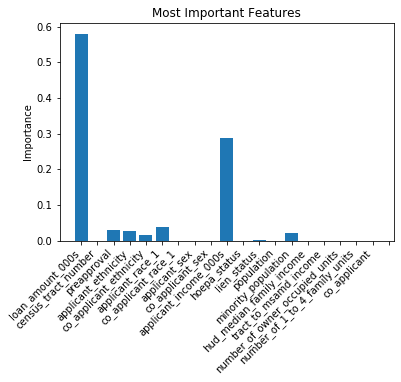

In [51]:
feature_scores_dtc = grid_dtc.best_estimator_.feature_importances_

# Plot
plt.figure()
plt.bar(features, feature_scores1)
plt.title('Most Important Features for Decision Tree Classifier')
plt.ylabel('Importance')
plt.xticks(range(20), feature_labels1, rotation=45, ha='right')
plt.show()

In [ ]:
fig2, ax2 = plt.subplots(1,1)
plot_precision_recall_curve(grid.best_estimator_, x_test, y_test, ax=ax2)
plot_precision_recall_curve(grid_r.best_estimator_, x_test_r, y_test_r, ax=ax2)

##### Thresholds Fixed Values

In [ ]:
probabilities = grid_r.best_estimator_.predict_proba(x_test_r)[:,1]
thresholds = [0,.3,.5,.7,.9]
scores = []
for i in thresholds:
    n = [(1 if a > i else 0) for a in probabilities]
    p = precision_score(y_test, n)
    r = recall_score(y_test, n)
    scores.append([i,p,r])
    
fixed_values = pd.DataFrame(scores)
fixed_values.columns = ['threshold', 'precision','recall']
fixed_values.head(6)

##### Thresholds Percentages

In [ ]:
probabilities = pd.DataFrame(grid_r.best_estimator_.predict_proba(x_test_r)[:,1])
probabilities.columns = ['scored']
probabilities['class'] = 0
thresholds = [.01,.05,.1,.2,.5,1]
scores = []

#mark
for i in thresholds:
    max_val = probabilities.shape[0]
    to_return = int((max_val * i))
    index_nums = probabilities.nlargest(to_return, columns = 'scored').index
    for j in index_nums:
        probabilities.iloc[j,1] = 1
    
    p = precision_score(y_test, probabilities['class'])
    r = recall_score(y_test, probabilities['class'])
    scores.append([i,p,r])
    
fixed_values = pd.DataFrame(scores)
fixed_values.columns = ['threshold', 'precision','recall']
fixed_values.head(6)

### Feature Importance

***
**OLD CODE UNDER HERE**

In [116]:
sample['label'] = np.where(sample['action_taken'] == 1, 1, 0)

features = sample.loc[:,['applicant_income_000s','population','minority_population','hud_median_family_income','tract_to_msamd_income','number_of_1_to_4_family_units']]
label = sample['label']

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = .2, random_state=0)

In [297]:
impute_features = SimpleImputer(missing_values=np.nan, strategy='median')
x_train = impute_features.fit_transform(x_train)
#impute test set with training medians
fill_values = dict(zip(features.columns.values, impute_features.statistics_))
x_test = x_test.fillna(value=fill_values)

In [120]:
parameters = {'random_state':[0],'max_depth':[2,3,5],'criterion':['entropy', 'gini'],'min_samples_split':[2,5,10]}

grid = GridSearchCV(DecisionTreeClassifier(), parameters, scoring = ['accuracy', 'recall', 'precision'], cv=10, refit='accuracy')

grid.fit(x_train, y_train)

results = pd.DataFrame.from_dict(grid.cv_results_)
results[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.726145,1.000000,0.726145
1,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.726145,1.000000,0.726145
2,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.726145,1.000000,0.726145
3,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.741112,0.983419,0.743122
4,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.741112,0.983419,0.743122
5,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.741112,0.983419,0.743122
6,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.744675,0.990799,0.743165
7,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.744675,0.990799,0.743165
8,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.744675,0.990799,0.743165
9,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.726145,1.000000,0.726145


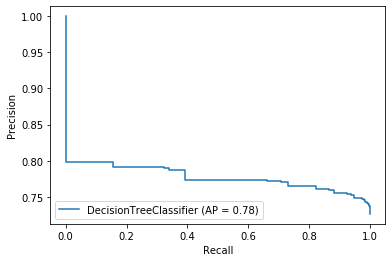

In [132]:
plot_precision_recall_curve(grid.best_estimator_, x_test, y_test)
plt.show()

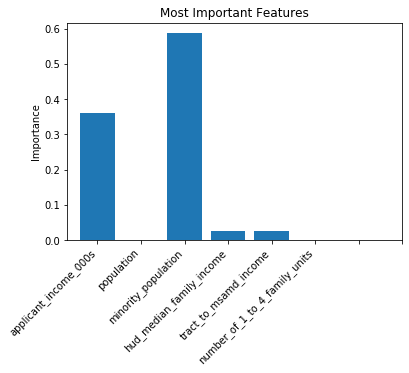

In [146]:
feature_scores1 = grid.best_estimator_.feature_importances_
feature_labels1 = features.columns.values
# Plot
plt.figure()
plt.bar(feature_labels1, feature_scores1)
plt.title('Most Important Features')
plt.ylabel('Importance')
plt.xticks(range(8), feature_labels1, rotation=45, ha='right')
plt.show()

Only using Census indicators provides limited accuracy. Limiting the outcome variables also, unsurprisingly, increases accuracy (not predicting pre approval, loan purchases, or approved but not accepted).

Including loan purpose, applicant one race, and sex:

In [144]:
features2 = sample.loc[:,['applicant_race_1','applicant_sex','population','minority_population','hud_median_family_income','number_of_1_to_4_family_units']]
label2 = sample['label']

x_train2, x_test2, y_train2, y_test2 = train_test_split(features2, label2, test_size = .2, random_state=0)

In [145]:
features2.shape

(5859273, 7)

In [175]:
impute_features2 = SimpleImputer(missing_values=np.nan, strategy='median')
x_train2 = impute_features2.fit_transform(x_train2)
fill_values2 = dict(zip(features2.columns.values, impute_features2.statistics_))
x_test2 = x_test2.fillna(value=fill_values2)

In [99]:
parameters2 = {'random_state':[0],'max_depth':[1,3,5],'criterion':['entropy', 'gini'],'min_samples_split':[2,5,10]}

grid2 = GridSearchCV(DecisionTreeClassifier(), parameters2, scoring = ['accuracy', 'recall', 'precision'], cv=10, refit='accuracy')

grid2.fit(x_train2, y_train2)

results2 = pd.DataFrame.from_dict(grid2.cv_results_)
results2[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
1,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
2,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
3,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.744592,0.997816,0.741490
4,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.744592,0.997816,0.741490
5,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.744592,0.997816,0.741490
6,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.744377,0.996388,0.741840
7,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.744377,0.996388,0.741840
8,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.744346,0.996346,0.741832
9,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.729607,1.000000,0.729607


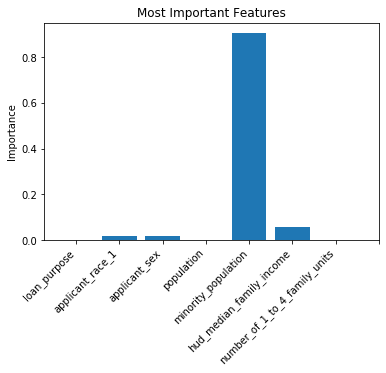

In [147]:
feature_scores = grid2.best_estimator_.feature_importances_
feature_labels = features2.columns.values
# Plot
plt.figure()
plt.bar(feature_labels, feature_scores)
plt.title('Most Important Features')
plt.ylabel('Importance')
plt.xticks(range(8), feature_labels, rotation=45, ha='right')
plt.show()

In [79]:
grid2.best_estimator_.feature_importances_

array([0.43690702, 0.11107877, 0.02931955, 0.00499694, 0.06915302,
       0.0584188 , 0.27275294, 0.01737295])

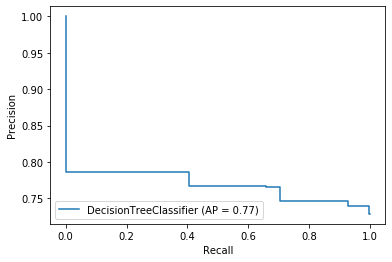

In [135]:
plot_precision_recall_curve(grid2.best_estimator_, x_test2, y_test2)

Trying a random forest model on a sample of ~30,000 observations:

In [138]:
parameters = {'random_state':[0],'n_estimators':[100,1000, 5000],'max_depth':[1,3,5],'criterion':['entropy', 'gini'],'min_samples_split':[2,5,10]}

grid_r = GridSearchCV(RandomForestClassifier(), parameters, scoring = ['accuracy', 'recall', 'precision'], cv=10, refit='accuracy', n_jobs = -1,verbose=2)
grid_r.fit(x_train2, y_train2)

results_r = pd.DataFrame.from_dict(grid_r.cv_results_)
results_r[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 52.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 78.1min finished


,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
1,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
2,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
3,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
4,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
5,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
6,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
7,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
8,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.729607,1.000000,0.729607
9,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.744683,0.997984,0.741499


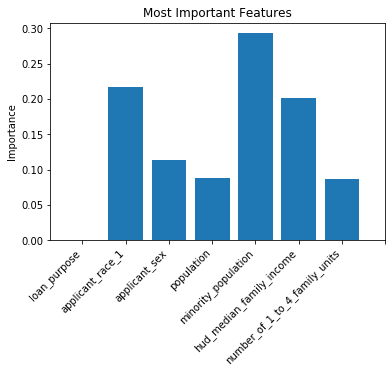

In [149]:
feature_scores_r = grid_r.best_estimator_.feature_importances_
feature_labels_r = features2.columns.values
# Plot
plt.figure()
plt.bar(feature_labels_r, feature_scores_r)
plt.title('Most Important Features')
plt.ylabel('Importance')
plt.xticks(range(8), feature_labels_r, rotation=45, ha='right')
plt.show()

In [177]:
confusion_matrix(y_test2, grid_r.predict(x_test2))

array([[     0, 320617],
       [     0, 851238]], dtype=int64)

In [179]:
x_test2.describe()

,loan_purpose,applicant_race_1,applicant_sex,population,minority_population,hud_median_family_income,number_of_1_to_4_family_units
count,1171855.0,1.171855e+06,1.171855e+06,1.171855e+06,1.171855e+06,1.171855e+06,1.171855e+06
mean,1.0,4.762797e+00,1.462729e+00,5.772106e+03,3.121926e+01,7.020756e+04,2.037327e+03
std,0.0,1.048623e+00,6.827281e-01,3.273103e+03,2.483788e+01,1.440681e+04,1.139855e+03
min,1.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.580000e+04,0.000000e+00
25%,1.0,5.000000e+00,1.000000e+00,3.875000e+03,1.173000e+01,6.150000e+04,1.365000e+03
50%,1.0,5.000000e+00,1.000000e+00,5.184000e+03,2.376000e+01,6.790000e+04,1.845000e+03
75%,1.0,5.000000e+00,2.000000e+00,6.818000e+03,4.482000e+01,7.520000e+04,2.456000e+03
max,1.0,7.000000e+00,4.000000e+00,5.381200e+04,1.000000e+02,1.315000e+05,2.539100e+04


## Remove non-essential features:

In [151]:
features3 = sample.loc[:,['loan_purpose','applicant_race_1','minority_population','tract_to_msamd_income']]
label3 = sample['label']

x_train3, x_test3, y_train3, y_test3 = train_test_split(features3, label3, test_size = .2, random_state=0)

In [154]:
impute_features3 = SimpleImputer(missing_values=np.nan, strategy='median')
x_train3 = impute_features3.fit_transform(x_train3)
fill_values3 = dict(zip(features3.columns.values, impute_features3.statistics_))
x_test3 = x_test3.fillna(value=fill_values3)

In [155]:
parameters3 = {'random_state':[0],'max_depth':[1,3,5],'criterion':['entropy', 'gini'],'min_samples_split':[2,5,10]}

grid3 = GridSearchCV(DecisionTreeClassifier(), parameters2, scoring = ['accuracy', 'recall', 'precision'], cv=10, refit='accuracy')

grid3.fit(x_train3, y_train3)

results3 = pd.DataFrame.from_dict(grid3.cv_results_)
results3[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.726145,1.000000,0.726145
1,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.726145,1.000000,0.726145
2,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.726145,1.000000,0.726145
3,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.741391,0.997782,0.738166
4,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.741391,0.997782,0.738166
5,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.741391,0.997782,0.738166
6,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.741525,0.997950,0.738208
7,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.741525,0.997950,0.738208
8,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.741525,0.997950,0.738208
9,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.726145,1.000000,0.726145


In [159]:
grid3.predict(x_test3)

array([1, 1, 1, ..., 0, 1, 1])

In [160]:
print('Precision: ', precision_score(y_test3, grid3.predict(x_test3)))
print('Recall: ', recall_score(y_test3, grid3.predict(x_test3)))
print('F1-Score: ', f1_score(y_test3, grid3.predict(x_test3)))

Precision:  0.7385436283741369
Recall:  0.9978795589482612
F1-Score:  0.8488455988455988
